# Importing appropriate libraries and modules

In [386]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
from pandas import Grouper
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline

# SP500 and VIX

"The CBOE Volatility Index, commonly known as the VIX, is calculated from options on the SPX cash index expiring between 23-37 days.. This gives the market’s anticipation of implied volatility (IV) for the next 30 days. When the market makes a larger move down traders look for protection and bid up puts which increases the VIX. Historically, investors have been afraid of a large down move and not a big up move since most investors are long stocks."

# Reading SP500 futures data and VIX
    Source: 
    https://www.investing.com/indices/us-spx-500-futures-historical-data
    
    https://www.macrotrends.net/2603/vix-volatility-index-historical-chart

In [387]:
sp500 = pd.DataFrame(pd.read_csv("S&P500FuturesHistoricalData.csv"))
vix= pd.DataFrame(pd.read_csv("vix-volatility-index.csv"))

In [388]:
sp500.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 12, 2017","2,388.75","2,390.25","2,391.50","2,384.25",1.09M,-0.09%
1,"May 11, 2017","2,391.00","2,395.00","2,395.25","2,379.00",1.36M,-0.18%
2,"May 10, 2017","2,395.25","2,391.75","2,397.00","2,387.50",998.86K,0.08%
3,"May 09, 2017","2,393.25","2,394.50","2,400.00","2,388.75",1.11M,-0.07%
4,"May 08, 2017","2,395.00","2,402.50","2,403.75","2,389.75",957.16K,-0.11%


In [389]:
vix.head()

,date,value
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [390]:
vix['date']= pd.to_datetime(vix['date'])

In [391]:
vix.head()

,date,value
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [392]:
sp500.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [393]:
sp500['Date']= pd.to_datetime(sp500['Date'])

In [394]:
sp500.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-05-12,"2,388.75","2,390.25","2,391.50","2,384.25",1.09M,-0.09%
1,2017-05-11,"2,391.00","2,395.00","2,395.25","2,379.00",1.36M,-0.18%
2,2017-05-10,"2,395.25","2,391.75","2,397.00","2,387.50",998.86K,0.08%
3,2017-05-09,"2,393.25","2,394.50","2,400.00","2,388.75",1.11M,-0.07%
4,2017-05-08,"2,395.00","2,402.50","2,403.75","2,389.75",957.16K,-0.11%


In [395]:
sp500.set_index('Date', inplace= True)

In [396]:
vix.set_index('date', inplace= True)

In [397]:
sp500.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-05-12,"2,388.75","2,390.25","2,391.50","2,384.25",1.09M,-0.09%
2017-05-11,"2,391.00","2,395.00","2,395.25","2,379.00",1.36M,-0.18%
2017-05-10,"2,395.25","2,391.75","2,397.00","2,387.50",998.86K,0.08%
2017-05-09,"2,393.25","2,394.50","2,400.00","2,388.75",1.11M,-0.07%
2017-05-08,"2,395.00","2,402.50","2,403.75","2,389.75",957.16K,-0.11%


In [398]:
sp500['Price']= sp500['Price'].apply(lambda x: x.replace(',',''))

In [399]:
vix.head()

,value
date,
1990-01-02,17.24
1990-01-03,18.19
1990-01-04,19.22
1990-01-05,20.11
1990-01-08,20.26


In [400]:
sp500['Price'] = sp500['Price'].astype('float64')

In [401]:
vix.rename(columns= {'value':'VIX'}, inplace= True)

In [402]:
sp500.rename(columns={'Price':'SP500ClosingPrice'}, inplace=True)

In [403]:
sp500closing= sp500['SP500ClosingPrice']

In [404]:
VIX= vix['VIX']

In [405]:
sp500closing.head()

Date
2017-05-12    2388.75
2017-05-11    2391.00
2017-05-10    2395.25
2017-05-09    2393.25
2017-05-08    2395.00
Name: SP500ClosingPrice, dtype: float64

In [406]:
VIX.head()

date
1990-01-02    17.24
1990-01-03    18.19
1990-01-04    19.22
1990-01-05    20.11
1990-01-08    20.26
Name: VIX, dtype: float64

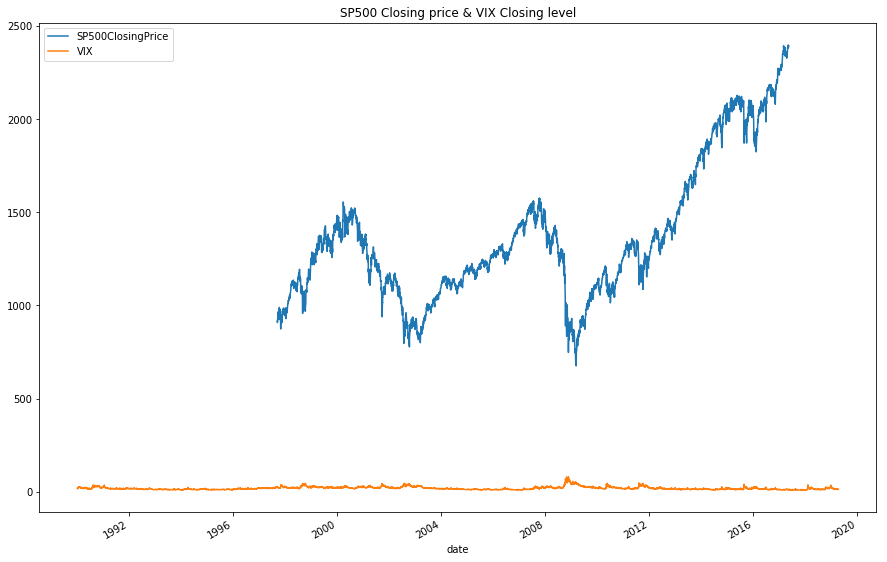

In [407]:
sp500closing.plot(figsize= (15,10))
VIX.plot()
plt.legend()
plt.title('SP500 Closing price & VIX Closing level')
plt.show();

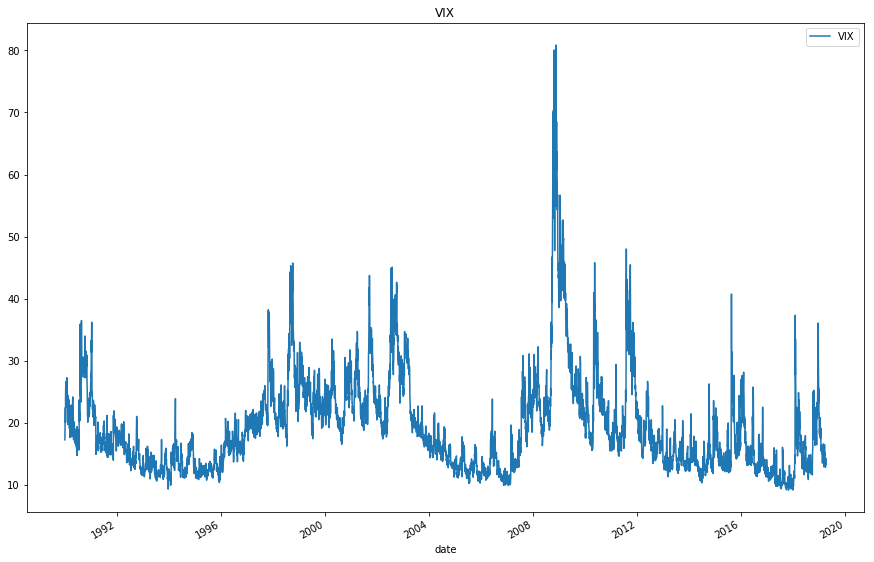

In [408]:
VIX.plot(figsize= (15,10))
plt.legend()
plt.title('VIX')
plt.show();

# Dickey Fuller Test on SP500 & VIX
    Fuller test and observation of chart shows SP500 not stationary. ??Surprise??

In [416]:
print( f" Pvalue for DickeyFuller test of closing prices is {adfuller(sp500closing)[1]} \n Conclusion: Data is not stationary.")

 Pvalue for DickeyFuller test of closing prices is 0.15577734017871037 
 Conclusion: Data is not stationary.


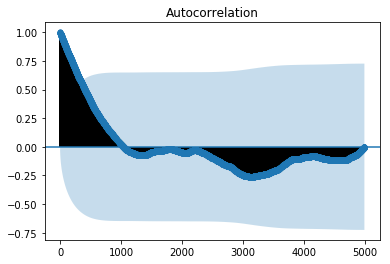

In [410]:
plot_acf(sp500closing);

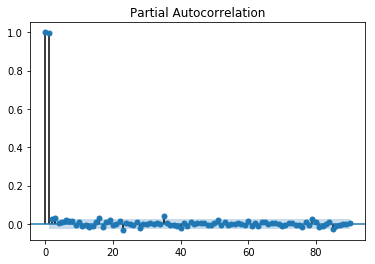

In [411]:
plot_pacf(sp500closing, lags= 90);

In [61]:
lag1daydiff = sp500closing.diff(periods= 1).dropna()

In [62]:
lag1daydiff.head()

Date
2017-05-11    2.25
2017-05-10    4.25
2017-05-09   -2.00
2017-05-08    1.75
2017-05-05    2.75
Name: SP500ClosingPrice, dtype: float64

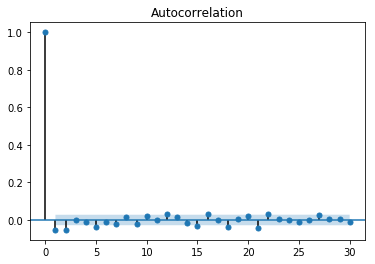

In [63]:
plot_acf(lag1daydiff, lags= 30);

## VIX is stationary

In [415]:
print( f" Pvalue for DickeyFuller test of VIX is {adfuller(VIX)[1]} \n Conclusion: VIX Data is stationary.")

 Pvalue for DickeyFuller test of VIX is 2.143401700412233e-06 
 Conclusion: VIX Data is stationary.


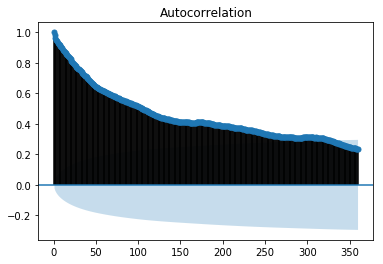

In [427]:
plot_acf(VIX, lags = 360);

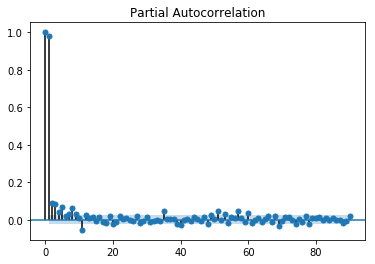

In [421]:
plot_pacf(VIX, lags= 90);

# Moving Averages & Stationarizing SP500 futures data

In [64]:
sp500rollingmean30 = sp500closing.rolling(30).mean()
sp500rollingstd30 = sp500closing.rolling(30).std()

sp500rollingmean30.dropna(inplace= True)
sp500rollingstd30.dropna(inplace= True)

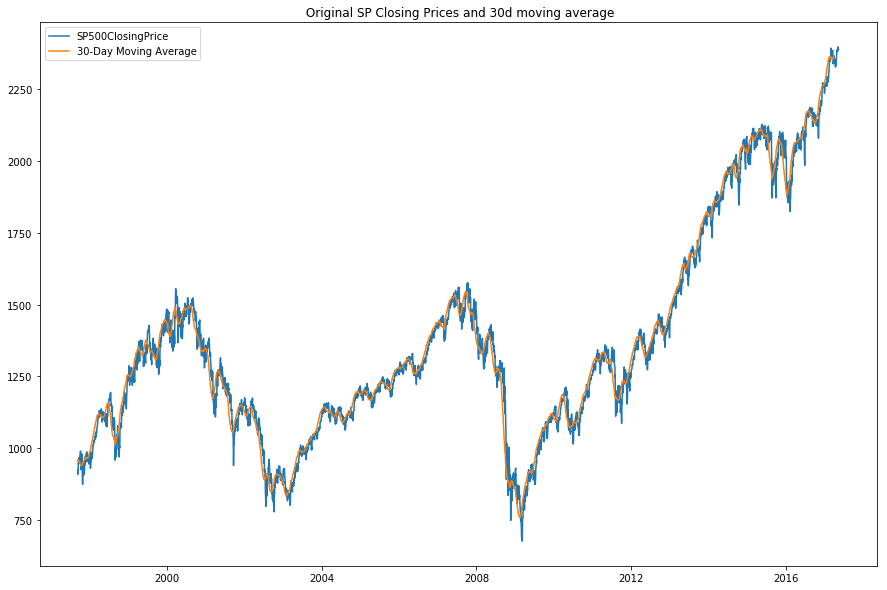

In [451]:
plt.figure(figsize=(15,10))
plt.plot(sp500closing)
plt.plot(sp500rollingmean30, label = '30-Day Moving Average')
plt.legend()
plt.title(" Original SP Closing Prices and 30d moving average")
plt.show();

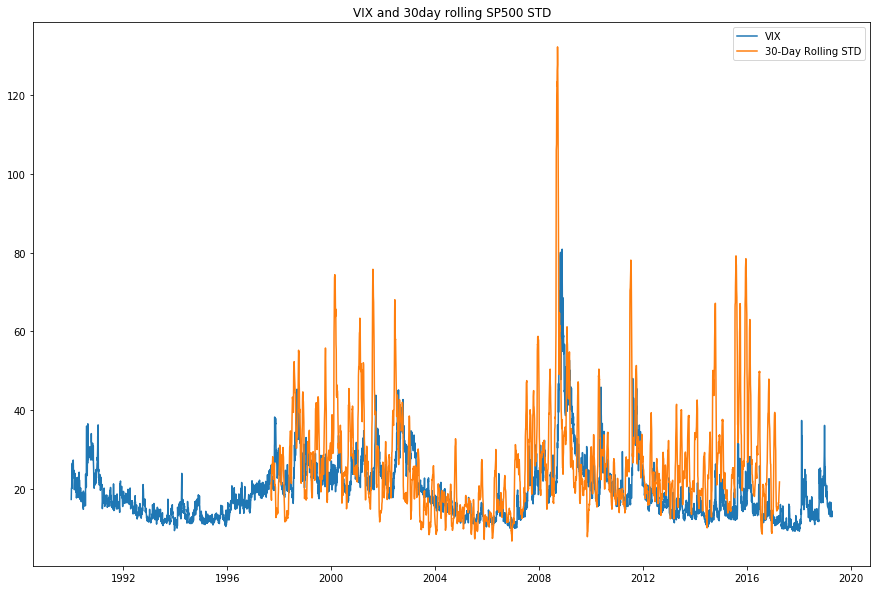

In [453]:
plt.figure(figsize=(15,10))
plt.plot(VIX)
plt.plot(sp500rollingstd30, label = '30-Day Rolling STD')
plt.legend()
plt.title("VIX and 30day rolling SP500 STD")
plt.show();

## Transforming the Data

In [430]:
logsp500= np.log(sp500closing)

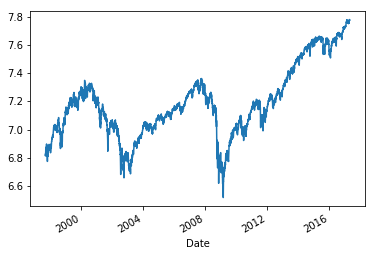

In [450]:
logsp500.plot();

In [443]:
logminusrollingmean = logsp500 - logsp500.rolling(30).mean()

In [448]:
logrollingstd= logsp500.rolling(30).std()

In [449]:
logrollingstd.dropna(inplace= True)

In [445]:
logminusrollingmean.dropna(inplace= True)

In [447]:
print( f" Pvalue for DickeyFuller test of Logdifference SP500 is {adfuller(logminusrollingmean)[1]} \n Conclusion: Data is stationary.")



 Pvalue for DickeyFuller test of Logdifference SP500 is 2.8308457281101394e-21 
 Conclusion: Data is stationary.


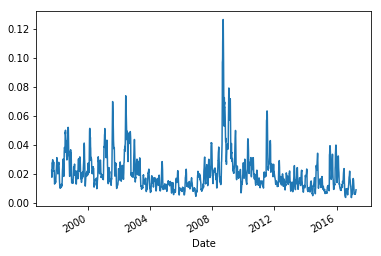

In [454]:
logrollingstd.plot();

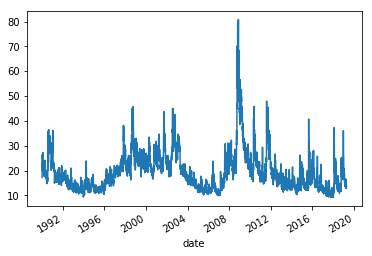

In [455]:
VIX.plot()

!pip install stldecompose

## Trying different decomposition methods

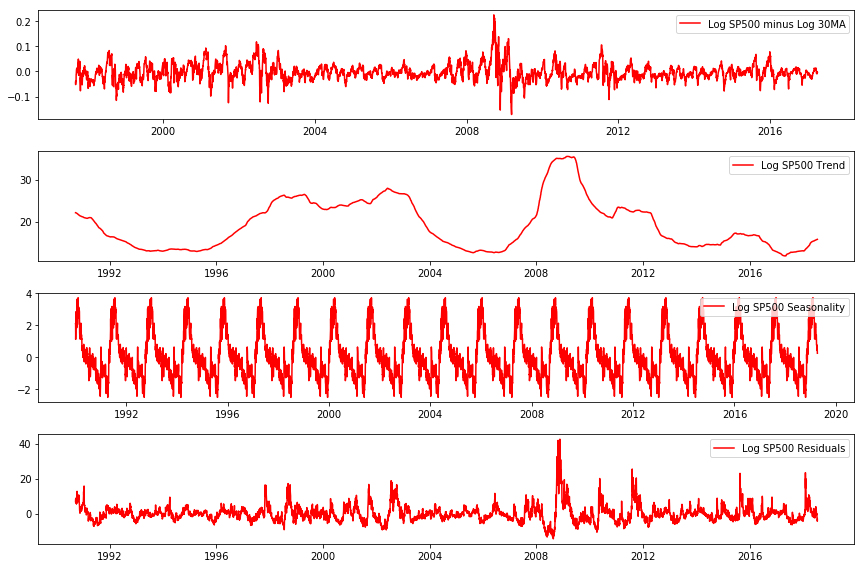

In [464]:
# import seasonal_decompose
decomposition = seasonal_decompose(logminusrollingmean, model= 'additive', freq=365)

# Gather the trend, seasonality and noise of decomposed object
logsptrend = decomposition.trend
logspseasonal = decomposition.seasonal
logspresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(logminusrollingmean, label='Log SP500 minus Log 30MA', color="red")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Log SP500 Trend', color="red")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Log SP500 Seasonality', color="red")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Log SP500 Residuals', color="red")
plt.legend(loc='best')
plt.tight_layout()

In [477]:
spdecomposedf= pd.concat({'Log SP500 minus Log 30MA': logminusrollingmean,'Log SP500 Trend': pd.Series(logsptrend), 'Log SP500 Seasonal' : pd.Series(logspseasonal), 'LogSP500 Residual' :pd.Series(logspresidual)}, axis=1).dropna()




In [478]:
spdecomposedf.head()

,Log SP500 Seasonal,Log SP500 Trend,Log SP500 minus Log 30MA,LogSP500 Residual
Date,,,,
2016-07-25,0.007481,-0.005222,-0.004763,-0.007022
2016-07-22,0.009205,-0.005238,-0.002177,-0.006144
2016-07-21,0.012157,-0.005224,-0.006427,-0.013359
2016-07-20,0.009081,-0.005193,-0.002004,-0.005891
2016-07-19,0.006594,-0.005166,-0.005795,-0.007223


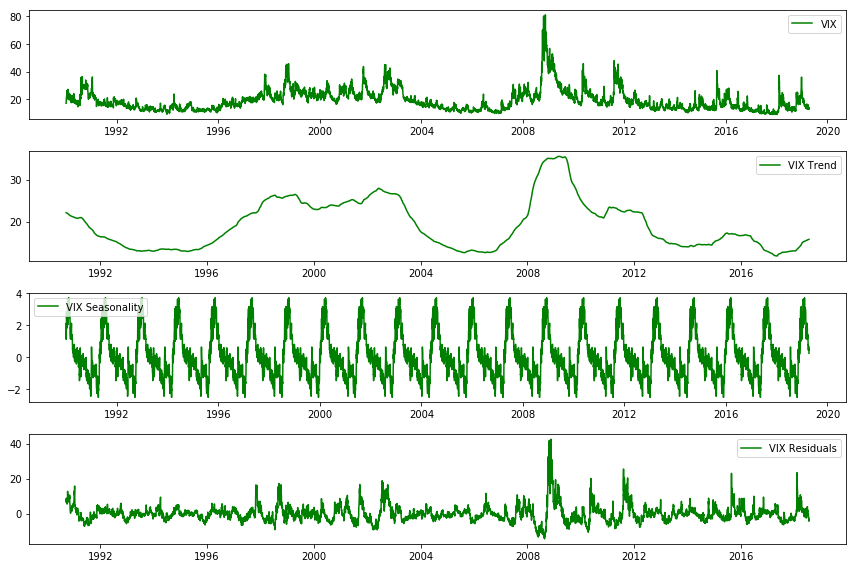

In [479]:
# import seasonal_decompose
decomposition = seasonal_decompose(VIX, model= 'additive', freq=365)

# Gather the trend, seasonality and noise of decomposed object
vixtrend = decomposition.trend
vixseasonal = decomposition.seasonal
vixresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(VIX, label='VIX', color="green")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='VIX Trend', color="green")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='VIX Seasonality', color="green")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='VIX Residuals', color="green")
plt.legend(loc='best')
plt.tight_layout()

In [470]:
vixdecomposedf= pd.concat({'VIX': VIX,'VIX Trend': pd.Series(vixtrend), 'VIX Seasonal' : pd.Series(vixseasonal), 'VIX Residual' :pd.Series(vixresidual)}, axis=1).dropna()




## Looking at the DataFrames

In [472]:
spdecomposedf.head()

,Log SP500 Seasonal,Log SP500 Trend,Log SP500 minus Log 30MA,Residual
Date,,,,
2016-07-25,0.007481,-0.005222,-0.004763,-0.007022
2016-07-22,0.009205,-0.005238,-0.002177,-0.006144
2016-07-21,0.012157,-0.005224,-0.006427,-0.013359
2016-07-20,0.009081,-0.005193,-0.002004,-0.005891
2016-07-19,0.006594,-0.005166,-0.005795,-0.007223


In [471]:
vixdecomposedf.head()

,VIX,VIX Residual,VIX Seasonal,VIX Trend
date,,,,
1990-09-20,28.66,6.901244,-0.368860,22.127616
1990-09-21,30.04,8.088733,-0.175664,22.126932
1990-09-24,30.56,8.846400,-0.407277,22.120877
1990-09-25,28.81,6.873841,-0.174526,22.110685
1990-09-26,28.19,6.444945,-0.354754,22.099808


# STL - Loess decomposition

STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while Loess is a method for estimating nonlinear relationships. The STL method was developed by Cleveland, Cleveland, McRae, & Terpenning (1990).

STL has several advantages over the classical, SEATS and X11 decomposition methods:

Unlike SEATS and X11, STL will handle any type of seasonality, not only monthly and quarterly data.

The seasonal component is allowed to change over time, and the rate of change can be controlled by the user.

The smoothness of the trend-cycle can also be controlled by the user.

It can be robust to outliers (i.e., the user can specify a robust decomposition), so that occasional unusual observations will not affect the estimates of the trend-cycle and seasonal components. They will, however, affect the remainder component.

On the other hand, STL has some disadvantages. In particular, it does not handle trading day or calendar variation automatically, and it only provides facilities for additive decompositions.

It is possible to obtain a multiplicative decomposition by first taking logs of the data, then back-transforming the components. Decompositions between additive and multiplicative can be obtained using a Box-Cox transformation of the data with  
0
<
λ
<
1
 . A value of  
λ
=
0
 corresponds to the multiplicative decomposition while  
λ
=
1
  is equivalent to an additive decomposition.

The best way to begin learning how to use STL is to see some examples and experiment with the settings. Figure 6.2 showed an example of STL applied to the electrical equipment orders data. Figure 6.13 shows an alternative STL decomposition where the trend-cycle is more flexible, the seasonal component does not change over time, and the robust option has been used. Here, it is more obvious that there has been a down-turn at the end of the series, and that the orders in 2009 were unusually low (corresponding to some large negative values in the remainder component).

In [473]:
decomp = decompose(logminusrollingmean, period= 365)

In [474]:
STLspdecomposedf= pd.concat({'Original': logminusrollingmean,'Trend': decomp.trend, 'Seasonal' : decomp.seasonal, 'Residual' : decomp.resid}, axis=1).dropna()
STLspdecomposedf.head()

,Original,Residual,Seasonal,Trend
Date,,,,
2017-03-31,-0.003348,-0.011345,0.013543,-0.005545
2017-03-30,-0.000785,-0.011781,0.016543,-0.005547
2017-03-29,-0.003485,-0.012301,0.014366,-0.005549
2017-03-28,-0.005206,-0.002408,0.002752,-0.005551
2017-03-27,-0.009979,-0.009966,0.005540,-0.005553


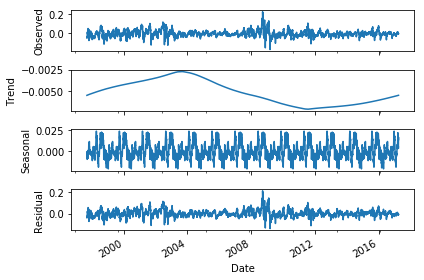

In [475]:
decomp.plot();

# Resample for months and years

In [258]:
sp500monthlyreturn = (sp500closing.resample('M').last() - sp500closing.resample('M').first())/ sp500closing.resample('M').first()

sp500annualreturn = (sp500closing.resample('Y').last() - sp500closing.resample('Y').first())/ sp500closing.resample('Y').first()
sp500annualreturn.dropna(inplace= True)



In [259]:
sp500annualreturn

Date
1997-12-31    0.069926
1998-12-31    0.264788
1999-12-31    0.196108
2000-12-31   -0.089824
2001-12-31   -0.115830
2002-12-31   -0.238302
2003-12-31    0.223691
2004-12-31    0.094454
2005-12-31    0.040207
2006-12-31    0.120612
2007-12-31    0.034127
2008-12-31   -0.382928
2009-12-31    0.200162
2010-12-31    0.110078
2011-12-31   -0.010077
2012-12-31    0.116352
2013-12-31    0.263555
2014-12-31    0.113704
2015-12-31   -0.011389
2016-12-31    0.113116
2017-12-31    0.064861
Freq: A-DEC, Name: SP500ClosingPrice, dtype: float64

# Grouping Months by Years for heat map

In [260]:
sp500monthlyreturn.dropna(inplace= True)

In [261]:
years_groups = sp500monthlyreturn.groupby(Grouper(freq='A'))

In [262]:
years_groups

In [263]:
#Create a new DataFrame and store yearly values in columns 
sp_annualgroup = pd.DataFrame()

for yr, group in years_groups:
    if len(group.values) == 12:
        sp_annualgroup[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
# sp_annualgroup.plot(figsize = (13,8), subplots=True, legend=True)
# plt.show();

In [264]:
months= ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']

In [265]:
sp_annualgroup = sp_annualgroup.T

In [311]:
sp_annualgroup.columns = months

In [312]:
sp_annualgroup

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
index,,,,,,,,,,,,
1998,0.003046,0.046315,0.057619,0.000894,-0.025463,0.043597,-0.009079,-0.142729,0.026513,0.110977,0.036836,0.060722
1999,0.032718,-0.030448,0.043785,0.034350,-0.053890,0.066538,-0.043316,-0.012274,-0.026837,0.063974,0.021284,0.058289
2000,-0.044827,-0.031586,0.094043,-0.044659,-0.037068,0.011368,-0.034552,0.050950,-0.045626,-0.010987,-0.077165,0.010981
2001,0.056357,-0.101627,-0.059710,0.090415,-0.011788,-0.026285,-0.024679,-0.070815,-0.077144,0.016726,0.053604,0.017441
2002,-0.020451,-0.014686,0.014790,-0.058759,-0.019293,-0.046977,-0.059825,0.036199,-0.071490,0.036885,0.041736,-0.060144
2003,-0.058127,-0.020384,0.013764,0.069157,0.052732,0.005164,0.008153,0.028841,-0.027397,0.032464,0.003320,0.038821
2004,0.018936,0.008814,-0.026395,-0.024261,0.003808,0.017168,-0.022420,-0.001357,0.007454,-0.002647,0.038249,0.020172
2005,-0.020311,0.012403,-0.021488,-0.016345,0.024710,-0.004787,0.030625,-0.012929,0.010231,-0.017861,0.037098,-0.007711
2006,0.006864,-0.003690,0.008707,0.007850,-0.027709,-0.004861,-0.005046,0.022518,0.025067,0.031891,0.021850,0.019993


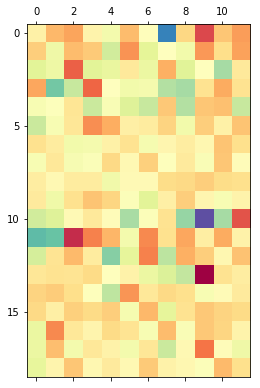

In [313]:
plt.matshow(sp_annualgroup, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.show();

# The January Effect= January returns predict annual returns

In [268]:
sp500monthly= pd.DataFrame(sp_annualgroup)

In [269]:
sp500monthly.reset_index(inplace=True)

In [270]:
sp500monthly['index'] = sp500monthly['index'].astype(str)

In [272]:
sp500monthly.set_index('index', inplace=True)

In [317]:
sp500monthly

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
index,,,,,,,,,,,,
1998,0.003046,0.046315,0.057619,0.000894,-0.025463,0.043597,-0.009079,-0.142729,0.026513,0.110977,0.036836,0.060722
1999,0.032718,-0.030448,0.043785,0.034350,-0.053890,0.066538,-0.043316,-0.012274,-0.026837,0.063974,0.021284,0.058289
2000,-0.044827,-0.031586,0.094043,-0.044659,-0.037068,0.011368,-0.034552,0.050950,-0.045626,-0.010987,-0.077165,0.010981
2001,0.056357,-0.101627,-0.059710,0.090415,-0.011788,-0.026285,-0.024679,-0.070815,-0.077144,0.016726,0.053604,0.017441
2002,-0.020451,-0.014686,0.014790,-0.058759,-0.019293,-0.046977,-0.059825,0.036199,-0.071490,0.036885,0.041736,-0.060144
2003,-0.058127,-0.020384,0.013764,0.069157,0.052732,0.005164,0.008153,0.028841,-0.027397,0.032464,0.003320,0.038821
2004,0.018936,0.008814,-0.026395,-0.024261,0.003808,0.017168,-0.022420,-0.001357,0.007454,-0.002647,0.038249,0.020172
2005,-0.020311,0.012403,-0.021488,-0.016345,0.024710,-0.004787,0.030625,-0.012929,0.010231,-0.017861,0.037098,-0.007711
2006,0.006864,-0.003690,0.008707,0.007850,-0.027709,-0.004861,-0.005046,0.022518,0.025067,0.031891,0.021850,0.019993


In [320]:
januaryeffect= pd.DataFrame(sp500monthly['Jan'])

In [321]:
januaryeffect.head()

,Jan
index,
1998,0.003046
1999,0.032718
2000,-0.044827
2001,0.056357
2002,-0.020451


In [322]:
januaryeffect.dtypes

Jan    float64
dtype: object

In [323]:
januaryeffect

,Jan
index,
1998,0.003046
1999,0.032718
2000,-0.044827
2001,0.056357
2002,-0.020451
2003,-0.058127
2004,0.018936
2005,-0.020311
2006,0.006864


In [324]:
sp500annualreturn

,SP500ClosingPrice
Date,
1997,0.069926
1998,0.264788
1999,0.196108
2000,-0.089824
2001,-0.115830
2002,-0.238302
2003,0.223691
2004,0.094454
2005,0.040207


In [325]:
sp500annualreturn= pd.DataFrame(sp500annualreturn)

In [326]:
sp500annualreturn.reset_index(inplace= True)

In [327]:
sp500annualreturn['Date']= sp500annualreturn['Date'].astype(str)

In [328]:
sp500annualreturn['Date']= sp500annualreturn['Date'].apply(lambda x: x[:4])

In [329]:
sp500annualreturn.head()

,Date,SP500ClosingPrice
0,1997,0.069926
1,1998,0.264788
2,1999,0.196108
3,2000,-0.089824
4,2001,-0.115830


In [330]:
sp500annualreturn.head()

,Date,SP500ClosingPrice
0,1997,0.069926
1,1998,0.264788
2,1999,0.196108
3,2000,-0.089824
4,2001,-0.115830


In [331]:
sp500annualreturn.set_index('Date', inplace= True)

In [332]:
sp500annualreturn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 1997 to 2017
Data columns (total 1 columns):
SP500ClosingPrice    21 non-null float64
dtypes: float64(1)
memory usage: 336.0+ bytes


In [333]:
januaryeffect.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 1998 to 2016
Data columns (total 1 columns):
Jan    19 non-null float64
dtypes: float64(1)
memory usage: 944.0+ bytes


In [334]:
jan_effect_df = pd.concat((sp500annualreturn, januaryeffect),axis =1)

In [336]:
jan_effect_df.dropna(inplace= True)

In [338]:
jan_effect_df.columns = ['AnnualReturnEnding', 'Jan Return']

In [344]:
jan_effect_df['Upyear']= jan_effect_df['AnnualReturnEnding'].apply(lambda x: x>0)
jan_effect_df['UpMonth']= jan_effect_df['Jan Return'].apply(lambda x: x>0)

In [347]:
jan_effect_df

,AnnualReturnEnding,Jan Return,Upyear,UpMonth
1998,0.264788,0.003046,True,True
1999,0.196108,0.032718,True,True
2000,-0.089824,-0.044827,False,False
2001,-0.115830,0.056357,False,True
2002,-0.238302,-0.020451,False,False
2003,0.223691,-0.058127,True,False
2004,0.094454,0.018936,True,True
2005,0.040207,-0.020311,True,False
2006,0.120612,0.006864,True,True
2007,0.034127,0.010151,True,True


In [360]:
jan_effect_df.corr()

,AnnualReturnEnding,Jan Return,Upyear,UpMonth
AnnualReturnEnding,1.000000,0.065448,0.810913,0.301446
Jan Return,0.065448,1.000000,-0.009209,0.854754
Upyear,0.810913,-0.009209,1.000000,0.190964
UpMonth,0.301446,0.854754,0.190964,1.000000


According to our correlation matrix an Upmonth is only lightly correlated to an up year ~ .20!